# Optimisation Bayesienne 

#### 1. Généralisation de réalisations de processus stochastique 1D

In [1]:
# Importation des librairies nécessaires
%matplotlib inline
import numpy as np
import numpy.linalg as LA
from numpy.random import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.linalg import sqrtm
from scipy.optimize import minimize
from scipy.stats import norm
from pyDOE import lhs
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
from IPython.display import display_javascript,HTML,Video
import os
import sys
import feuDeForet as fdf
import trieste
import tensorflow as tf
import gpflow
import tensorflow_probability as tfp
from trieste.models.gpflow.models import GaussianProcessRegression
from trieste.data import Dataset
from trieste.acquisition.rule import EfficientGlobalOptimization

2022-01-22 19:43:42.622090: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-22 19:43:42.622117: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-22 19:43:44.310523: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-22 19:43:44.310552: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-22 19:43:44.310570: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (enzo-XPS-13-9305): /proc/driver/nvidia/version does not exist
2022-01-22 19:43:44.310853: I tensorflow/core/platform/cpu_f

In [2]:
# Fonctions de covariances de processus gaussiens
# Le décorateur @np.vectorize sert à ce qu'on puisse utiliser les fonctions sur des vecteurs

@np.vectorize
def kg(x1,x2,theta=0.2,sigma=1):
    """
    Noyau de covariance gaussien
    """
    return sigma**2*np.exp(-(LA.norm(x1-x2)/theta)**2)

@np.vectorize
def ke(x1,x2,theta=0.2,sigma=1):
    """
    Noyau de covariance exponentiel
    """
    return sigma**2*np.exp(-LA.norm(x1-x2)/theta)

@np.vectorize
def kb(x1,x2):
    """
    Noyau de covariance d'un mouvement brownien (ne fonctionne qu'en 1D)
    """
    return min(x1,x2)



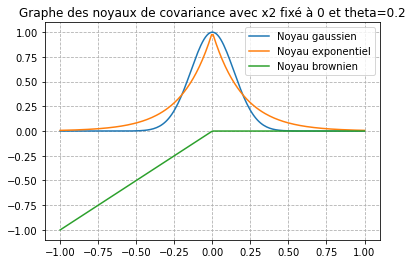

In [3]:
#%matplotlib inline
x1 = np.linspace(-1,1,200)
x2 = 0
theta=0.2
plt.title(f"Graphe des noyaux de covariance avec x2 fixé à {x2} et theta={theta}")
plt.plot(x1,kg(x1,x2,theta),label="Noyau gaussien")
plt.plot(x1,ke(x1,x2,theta),label="Noyau exponentiel")
plt.plot(x1,kb(x1,x2),label="Noyau brownien")
plt.legend()
plt.grid(ls="--")
#plt.savefig("noyaux.png")
plt.show()

In [4]:
np.random.seed(0)
def plot_gaussian_process(sigma,theta):
    n2=100
    x = np.linspace(0,1,n2)
    Kg = np.array([[kg(xi,xj,theta,sigma) for xi in x] for xj in x])
    Ke = np.array([[ke(xi,xj,theta,sigma) for xi in x] for xj in x])
    Z = multivariate_normal(np.zeros((n2,)),np.eye(n2,n2))
    Yg = np.real(sqrtm(Kg))@Z
    Ye = np.real(sqrtm(Ke))@Z
    plt.title(f"Graphe de réalisations de processus gaussiens \navec les noyaux gaussien et exponentiel avec $\sigma$={sigma} et $\\theta$={theta}")
    plt.plot(x,np.array([Yg,Ye]).T)
    plt.legend(["Noyau Gaussien","Noyau exponentiel"])
    plt.grid(ls="--")
    #plt.savefig('realisation.png')
    plt.show()

interact(plot_gaussian_process,theta=(0.05,0.50,0.05),sigma=(1,10))
plt.show()
print()

interactive(children=(IntSlider(value=5, description='sigma', max=10, min=1), FloatSlider(value=0.25, descript…

Plus $\theta$ est petit plus le processus varie et $σ$ influe sur l'amplitude des variations.

#### 2. Métamodélisation

Dans cette partie on crée un méta-modèle de la fonction de Branin, qui est une fonction utilisé pour mesurer l'efficacité des méthodes d'optimisation.

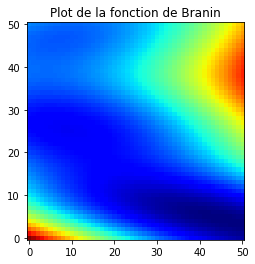

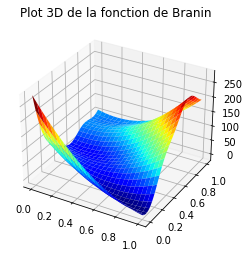

In [5]:
def fb(x):
    """
    Fonction de Branin avec les variables normalisées
    """
    pi = np.pi
    x1,x2 = x
    x1 = 15*x1-5
    x2 = 15*x2
    return (x2-5.1/(4*pi**2)*x1**2+5/pi*x1-6)**2+10*((1-1/(8*pi))*np.cos(x1)+1)+5*x1

N=51
x1 = np.linspace(0,1,N)
x2 = np.linspace(0,1,N)

def eval_func(x1,x2,f):
    X1,X2 = np.meshgrid(x1,x2)
    Z = np.zeros(X1.shape)
    for i,xi in enumerate(x1):
        for j,xj in enumerate(x2):
            Z[i,j]=f([xi,xj])
    return X1,X2,Z
X1,X2,Z = eval_func(x1,x2,fb)
plt.title("Plot de la fonction de Branin")
plt.imshow(Z,cmap=cm.jet,origin="lower")
#plt.savefig("branin.png")
plt.show()
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.set_title("Plot 3D de la fonction de Branin")
ax.plot_surface(X1,X2,Z,cmap=cm.jet)
plt.show()



On définit les fonctions pour le krigeage :

L'estimateur du krigeage est donné par $m_n(x) = \sum_{i=1}^n \lambda_i y_i$, $K_nλ =k_n$ où $K_n = (k(x_i,x_j))$ et $k_n = (k(x,x_i))$.

Le système est obtenu en imposant que l'estimateur soit non-biaisé et qu'il minimise la variance de l'erreur.

In [6]:
if type(kg)==type(np.vectorize(lambda x:x)):
    kg = kg.pyfunc

def r(X1,X2,k_func=kg):
    if type(X1)==list:
        X1 = np.array(X1).reshape(1,-1)
    if type(X2)==list:
        X2 = np.array(X2).reshape(1,-1)
    R = np.zeros((X1.shape[0],X2.shape[0]))
    for i,xi in enumerate(X1):
        for j,xj in enumerate(X2):
            R[i,j] = k_func(xi,xj)
    return R

def y_func(X):
    y = np.zeros((len(X),1))
    for i,xi in enumerate(X):
        y[i] = fb(xi)
    return y

def mn(x,X,y,k_func=kg):
    r_vec = r(x,X,k_func)
    R_mat = r(X,X,k_func)
    return r_vec@(np.linalg.solve(R_mat,y))

def sigman2(Xn,y,k_func=kg):
    R_mat = r(Xn,Xn,k_func)
    n = R_mat.shape[0]
    return 1/n*y.T@(LA.solve(R_mat,y))

def vn(x,X,y,k_func=kg):
    r_vec = r(x,X,k_func=k_func).T
    sigma2 = sigman2(X,y,k_func=k_func)
    Rn = r(X,X,k_func=k_func)
    c = np.sum(r_vec*(LA.solve(Rn,r_vec)),axis=0)
    return sigma2*(1-c)


On essaie avec une grille uniforme comme plan d'expérience.

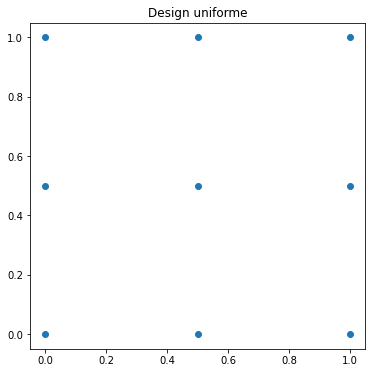

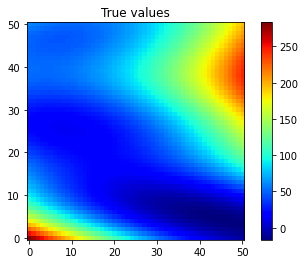

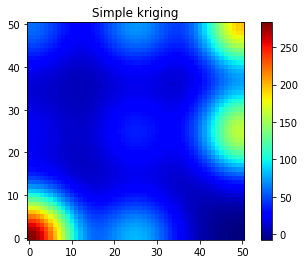

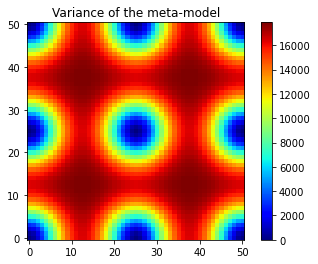

Erreur en norme L2 entre Z_true et Z: 2494.611526682984


In [7]:
x_uni = np.linspace(0,1,num=3)
X_uni = np.array([[xi,xj] for xi in x_uni for xj in x_uni])
y = y_func(X_uni)
plt.figure(figsize=(6,6))
plt.scatter(X_uni[:,0],X_uni[:,1])
plt.title("Design uniforme")
plt.show()
n_test = 51
x_test = np.linspace(0,1,n_test)
X_test = np.array([[xi,xj] for xi in x_test for xj in x_test])
_,_,Z_true = eval_func(x_test,x_test,lambda x: fb(x))
Z = mn(X_test,X_uni,y).reshape(n_test,n_test)
S = vn(X_test,X_uni,y).reshape(n_test,n_test)
#fig,(ax1,ax2,ax3) = plt.subplots(1,3)
#fig.set_size_inches(20, 20)
plt.imshow(Z_true,cmap=cm.jet,origin="lower")
plt.colorbar(shrink=1)
plt.title("True values")
plt.show()
plt.imshow(Z,cmap=cm.jet,origin="lower")
plt.colorbar(shrink=1)
plt.title("Simple kriging")
#plt.savefig("SimpleKrig.png")
plt.show()
plt.imshow(S,cmap=cm.jet,origin="lower")
plt.colorbar(shrink=1)
plt.title("Variance of the meta-model")
#plt.savefig("var.png")
plt.show()


print(f"Erreur en norme L2 entre Z_true et Z: {LA.norm(Z_true-Z)}")

On essaie avec un lhs avec un critère maximin optimisé

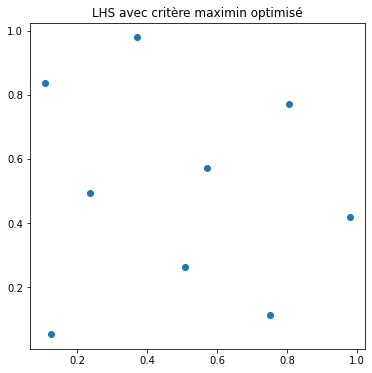

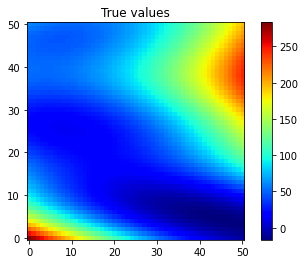

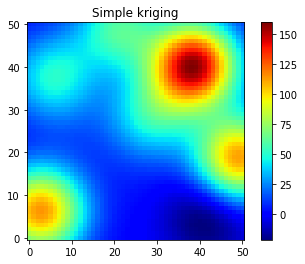

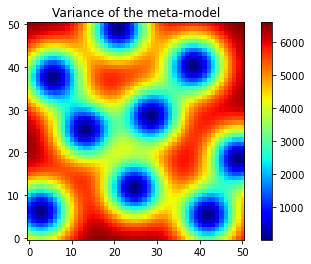

Erreur en norme L2 entre Z_true et Z: 2351.551838883435


In [9]:
X_lhs = lhs(2,9,criterion="maximin",iterations=100)
y = y_func(X_lhs)
plt.figure(figsize=(6,6))
plt.scatter(X_lhs[:,0],X_lhs[:,1])
plt.title("LHS avec critère maximin optimisé")
plt.show()

n_test = 51
x_test = np.linspace(0,1,n_test)
X_test = np.array([[xi,xj] for xi in x_test for xj in x_test])
_,_,Z_true = eval_func(x_test,x_test,lambda x: fb(x))
Z = mn(X_test,X_lhs,y).reshape(n_test,n_test)
S = vn(X_test,X_lhs,y).reshape(n_test,n_test)
plt.imshow(Z_true,cmap=cm.jet,origin="lower")
plt.colorbar(shrink=1)
plt.title("True values")
plt.show()
plt.imshow(Z,cmap=cm.jet,origin="lower")
plt.colorbar(shrink=1)
plt.title("Simple kriging")
#plt.savefig("SimpleKrig2.png")
plt.show()
plt.imshow(S,cmap=cm.jet,origin="lower")
plt.colorbar(shrink=1)
#plt.title("Variance of the meta-model")
plt.savefig("var2.png")
plt.show()


print(f"Erreur en norme L2 entre Z_true et Z: {LA.norm(Z_true-Z)}")

On a une erreur un peu moins grande avec le LHS qu'avec la grille uniforme.

On optimise maintenant le paramètre $\theta$ du noyau gaussien.

Pour cela on calcule la log-vraissemblance de $\theta$ vis à vis des observations et on l'optimise.

Cette fonction étant concave sur $[0,1]$ on utilise une méthode gradient pour l'optimiser, comme BFGS.

θ_opt = 0.6286469248423951


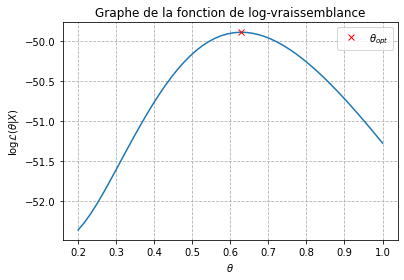

In [10]:
@np.vectorize
def ll(theta,X=X_lhs,y=y):
    """
    Fonction de log-vraissemblance log-L(θ|X)
    """
    n = len(X)
    sn = sigman2(X,y,lambda x1,x2: kg(x1,x2,theta=theta))
    Rn = r(X,X,lambda x1,x2: kg(x1,x2,theta=theta))
    return (-n/2*np.log(2*np.pi)-n/2*np.log(sn)-1/2*np.log(LA.det(Rn))-n/2)[0][0]
theta = np.linspace(0.2,1)
#On utilise BFGS (methode de gradient) parce que la fonction est concave que c'est ce qui a de plus efficace dans ce cas.
theta_opt = minimize(lambda t: -ll(t),0.2,method="BFGS").x
print(f"θ_opt = {theta_opt[0]}")
plt.plot(theta,ll(theta))
plt.plot(theta_opt,ll(theta_opt),"rx",label="$\\theta_{opt}$")
plt.title("Graphe de la fonction de log-vraissemblance")
plt.xlabel("$\\theta$")
plt.ylabel("$\log\mathcal{L}(\\theta|X)$")
plt.grid(ls="--")
plt.legend()
#plt.savefig("theta_graphe.png")
plt.show()

#### 3. EGO

Dans cette partie on optimise la fonction de Branin en utilisant le krigeage.

On part d'un plan d'expérience $\mathcal{X}$ et on évalue chacun de ces points $y = f(\mathcal{X})$.

On note ensuite $y_{min} = \min(y)$.

A partir de là on crée un métamodèle de krigeage de la fonction $f_b$ à partir de ces données.

On peut ensuite calculer l'espérence espérée qu'un point améliore $y_{min}$ : 

$$EI(x) = \mathbb{E}[\max(y_{min}-x,0)|\mathcal{X},y]$$

On maximise ensuite cette fonction et on rajoute au plan d'expérience et à $y$ ce maximum et sa valeur.

On réitère ensuite ce procédé jusqu'à atteindre notre budget en évaluations.

In [11]:
def EI(x,X,y):
    """
    Fonction d'amélioration espérée (Expected improvement)
    E[max(ymin-Y,0)]
    """
    k_func = lambda x1,x2: kg(x1,x2,theta=theta_opt)
    ymin = np.min(y)
    mx = mn(x,X,y,k_func=k_func)
    sn = np.sqrt(vn(x,X,y,k_func=k_func)).T
    return (ymin-mx)*norm.cdf((ymin-mx)/sn)+sn*norm.pdf((ymin-mx)/sn)


    

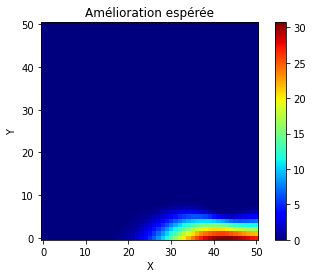

In [13]:
EI_res = EI(X_test,X_lhs,y_func(X_lhs)).reshape(n_test,n_test)
pl = plt.imshow(EI_res,cmap=cm.jet,origin="lower")
plt.title("Amélioration espérée")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(pl)
#plt.savefig("EI.png")
plt.show()

On utilise BFGS comme optimiseur.

In [16]:
def EGO_one_step(X,y):
    # penalization function
    p = lambda x: 1000*(x[0]<0 or x[0]>1 or x[1]<0 or x[1]>1)
    J = lambda x: p(x)-EI(x,X,y)[0][0]
    x = minimize(J,np.random.rand(2,1),method="BFGS").x
    return x

def EGO_n_steps(X,n=1,hist=False):
    X_c = np.copy(X)
    y = y_func(X_c)
    y_min_vec = []
    for _ in range(n):
        if hist:
            y_min_vec.append(np.min(y))
        x = EGO_one_step(X_c,y)
        X_c = np.vstack([X_c,x])
        y = np.vstack([y,y_func(x.reshape(1,2))])
        
    if hist:
        return X_c,X_c[np.argmin(y)],np.min(y),len(X_c),y_min_vec
    return X_c,X_c[np.argmin(y)],np.min(y),len(X_c)

X2,x_opt,y_min,neval,y_minvec = EGO_n_steps(X_lhs,11,hist=True)

In [17]:
p = lambda x: 1000*(x[0]<0 or x[0]>1 or x[1]<0 or x[1]>1)
J = lambda x: p(x)+fb(x)
x0 = np.array([1/2,1/2])
x_nelder = minimize(J,x0,method="Nelder-Mead",options={"maxiter":10,"return_all":True})
x_bfgs = minimize(J,x0,method="BFGS",options={"maxiter":5,"return_all":True})
print(x_opt,y_min,neval)
print(x_nelder.x,x_nelder.fun,x_nelder.nfev)
print(x_bfgs.x,x_bfgs.fun,x_bfgs.nfev)

[0.1082724  0.83651622] -16.130783105533812 20
[0.5015625 0.18125  ] 14.799644570908196 20
[0.50605523 0.18296545] 14.771944215634258 21


On voit que EGO s'en sort mieux avec un nombre d'itérations restreint.
Cette remarque dépend bien sûr du choix du $x_0$ et sûrement de la run.

#### 4. Propagation du feu de forêt

Dans cette partie on optimise une pare-feu pour minimiser la quantité de végétations brûlées lors d'un incendi dans une simulation numérique.

Le domaine de simulation est $\Omega = [0,1]^2$.

Le pare-feu est une zone rectangulaire de végétation défrichée. Il est déterminé par 4 coordonnées 
$(x_{min},x_{max},y_{min},y_{max}) = x$. 

On impose que le pare-feu soit au dessus la ligne $y=0.2$.

Au début on utilise une fonction pénalisée pour prendre en compte les contraintes : 

On note notre ensemble d'amissibilité $\mathcal{A} = \{ x\in\mathbb{R}^4 : y_{min}\geq0.2 \text{ et } y_{min}\leq y_{max} \text{ et } x_{min}\leq x_{max}\}$

Notre fonction coût pénalisé est ainsi donné par : $J_{penalized}(x) = J(x) + 100(1-\mathbf{1}_\mathcal{A}(x))$

In [18]:
# Cette partie est inspirée du tutoriel sur le site de Trieste: 
# https://secondmind-labs.github.io/trieste/notebooks/expected_improvement.html

space = trieste.space.Box([0,0,0.2,0.2],[1,1,1,1])

J = lambda t: tf.reshape(tf.map_fn(lambda x: fdf.cost_func(*x),t,parallel_iterations=4),[-1,1])
observer = trieste.objectives.utils.mk_observer(J)
num_initial = 15
doe = space.sample_sobol(num_initial)
initial_data = observer(doe)

def build_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.SquaredExponential(variance=variance)
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    gpflow.set_trainable(gpr.likelihood, False)

    return GaussianProcessRegression(gpr, num_kernel_samples=100)


model = build_model(initial_data)

bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, space)

num_steps = 20
result = bo.optimize(num_steps, initial_data, model)
dataset = result.try_get_final_dataset()
query_points = dataset.query_points.numpy()
observations = dataset.observations.numpy()

arg_min_idx = tf.squeeze(tf.argmin(observations, axis=0))

print(f"query point: {query_points[arg_min_idx, :]}")
print(f"observation: {observations[arg_min_idx, :]}")

2022-01-22 19:45:47.883523: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Optimization completed without errors
query point: [0.45184842 0.82673824 0.2        0.6276865 ]
observation: [2.24413432]


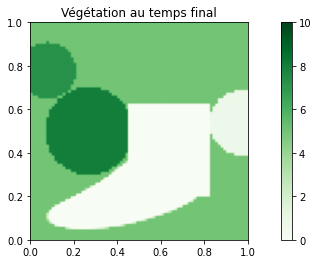

<Figure size 432x288 with 0 Axes>

In [19]:
%matplotlib inline
x_opt = query_points[arg_min_idx,:]
C,T = fdf.simu(*x_opt)
fdf.plot(C)

Optimization avec la contrainte incluse dans la fonction d'acquisition. La nouvelle fonction d'acquisitions est donnée par : 

$$EIC(x) = EI(x)\mathbb{P}(x\in\mathcal{A})$$

où l'ensemble des points admissibles est $\{x\in\mathbb{R}^4 : x\in\mathcal{A}\}$.

D'un point de vue pratique on réécrie notre ensemble d'admissibilité comme étant : $\mathcal{A} = \{x\in\mathbb{R}^4 : c(x)\leq h\}$ où $c:\mathbb{R^4}\to\mathbb{R}$ et $h\in\mathbb{R}$. 

In [20]:

J2 = lambda t: tf.reshape(tf.map_fn(lambda x: fdf.cost_func_unpenalized(*x),t),[-1,1])
def contraint(x):
    xmin,xmax,ymin,ymax = x
    
    return np.float64(xmin>xmax or ymin>ymax)
C = lambda t: tf.reshape(tf.map_fn(contraint,t),[-1,1]) 
def observer(query_points):
    return {
        "OBJECTIVE":Dataset(query_points,J2(query_points)),
        "CONSTRAINT":Dataset(query_points,C(query_points))
    }

initial_data = observer(doe)
pof = trieste.acquisition.ProbabilityOfFeasibility(threshold=1/2)
eci = trieste.acquisition.ExpectedConstrainedImprovement(
    "OBJECTIVE", pof.using("CONSTRAINT")
)
rule = EfficientGlobalOptimization(eci) 

num_steps = 20
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, space)


initial_models = trieste.utils.map_values(build_model, initial_data)


dataset = bo.optimize(
    num_steps, initial_data, initial_models, rule, track_state=False
).try_get_final_datasets()

dataset = dataset["OBJECTIVE"]

query_points = dataset.query_points.numpy()
observations = dataset.observations.numpy()

arg_min_idx = tf.squeeze(tf.argmin(observations, axis=0))

print(f"query point: {query_points[arg_min_idx, :]}")
print(f"observation: {observations[arg_min_idx, :]}")

Optimization completed without errors
query point: [0.43281378 0.85078329 0.2        0.35717424]
observation: [1.65432929]


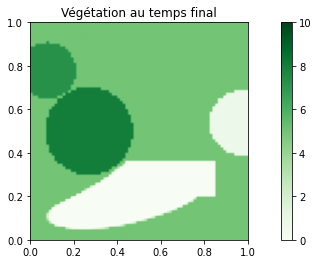

<Figure size 432x288 with 0 Axes>

In [21]:
%matplotlib inline
x_opt = query_points[arg_min_idx,:]
C,T = fdf.simu(*x_opt)
fdf.plot(C)

On a un résultat meilleur avec la deuxième approche.

On regarde pas maintenant le cas maintenant où nos entrées sont perturbées par un bruit $\epsilon\sim\mathcal{U}(-\delta,\delta)$ avec $\delta=0.025$. On veut maintenant optimiser l'espérance du la fonction coût. Pour ce faire on estime l'espérance avec un estimateur de Monte-Carlo: 
$$\mathbb{E}[J(X)] = \frac{1}{n}\sum_{i=1}^n J(x_i)$$

où les $x_i$ sont des réalisations i.i.d. de nos entrées.

In [23]:
n=10
J2 = lambda t: tf.reshape(tf.map_fn(lambda x: fdf.cost_func_MC(*x,n=n),t),[-1,1])
def contraint(x):
    xmin,xmax,ymin,ymax = x
    
    return np.float64(xmin>xmax or ymin>ymax)
C = lambda t: tf.reshape(tf.map_fn(contraint,t),[-1,1]) 
def observer(query_points):
    return {
        "OBJECTIVE":Dataset(query_points,J2(query_points)),
        "CONSTRAINT":Dataset(query_points,C(query_points))
    }

initial_data = observer(doe)
pof = trieste.acquisition.ProbabilityOfFeasibility(threshold=1/2)
eci = trieste.acquisition.ExpectedConstrainedImprovement(
    "OBJECTIVE", pof.using("CONSTRAINT")
)
rule = EfficientGlobalOptimization(eci) 

num_steps = 20
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, space)


initial_models = trieste.utils.map_values(build_model, initial_data)


dataset = bo.optimize(
    num_steps, initial_data, initial_models, rule, track_state=False
).try_get_final_datasets()

dataset = dataset["OBJECTIVE"]

query_points = dataset.query_points.numpy()
observations = dataset.observations.numpy()

arg_min_idx = tf.squeeze(tf.argmin(observations, axis=0))

print(f"query point: {query_points[arg_min_idx, :]}")
print(f"observation: {observations[arg_min_idx, :]}")

Optimization completed without errors
query point: [0.43860426 0.87865786 0.2        0.41512156]
observation: [1.82035509]


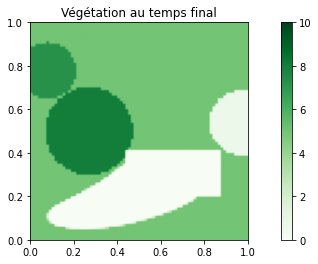

<Figure size 432x288 with 0 Axes>

In [24]:
%matplotlib inline
x_opt = query_points[arg_min_idx,:]
C,T = fdf.simu(*x_opt)
fdf.plot(C)

Le résultat dépend beaucoup de la run. Dans ma run j'obtient un pare-feu plus grand que précédemment.